In [14]:
from src.blackscholes import *
from src.pinn import *
from src.collocation import *
from src.differential import BlackScholesDifferential
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define hyperparameters
input_dim = 2  # tau and S
hidden_dim = 50
output_dim = 1  # Option price
num_hidden_layers = 3
num_epochs = 10000
learning_rate = 0.0001

# Instantiate model and collocation generator
model = PINN(input_dim, hidden_dim, output_dim, num_hidden_layers)
params = BlackScholesParams(K=100, r=0.05, sigma=0.2)
option = BlackScholesCall(params)
collocation = CollocationBlackScholes(option, t_max=1.0, S_max=500.0, n=5000)
differential = BlackScholesDifferential(option)

# Train the PINN
trained_model = train_pinn(
    model=model,
    collocation=collocation,
    differential=differential,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
)

Epoch 100/10000, PDE Loss: 0.008848, Boundary Loss: 129833.726562, Total Loss: 129833.734375
Epoch 200/10000, PDE Loss: 0.047349, Boundary Loss: 60035.203125, Total Loss: 60035.250000
Epoch 300/10000, PDE Loss: 0.143784, Boundary Loss: 9469.623047, Total Loss: 9469.766602
Epoch 400/10000, PDE Loss: 0.199615, Boundary Loss: 2051.773926, Total Loss: 2051.973633
Epoch 500/10000, PDE Loss: 0.126586, Boundary Loss: 1997.575439, Total Loss: 1997.702026
Epoch 600/10000, PDE Loss: 0.058430, Boundary Loss: 2047.032471, Total Loss: 2047.090942
Epoch 700/10000, PDE Loss: 0.001444, Boundary Loss: 1982.307617, Total Loss: 1982.309082
Epoch 800/10000, PDE Loss: 0.032405, Boundary Loss: 1989.198364, Total Loss: 1989.230713
Epoch 900/10000, PDE Loss: 0.128769, Boundary Loss: 1887.129517, Total Loss: 1887.258301
Epoch 1000/10000, PDE Loss: 0.203531, Boundary Loss: 1812.123901, Total Loss: 1812.327393
Epoch 1100/10000, PDE Loss: 0.221763, Boundary Loss: 1790.720825, Total Loss: 1790.942627
Epoch 1200/10

In [4]:
num_points = 100
S_vals = np.linspace(0, 500, num_points)
tau_vals = np.linspace(0, 1, num_points)
S_grid, tau_grid = np.meshgrid(S_vals, tau_vals)

In [7]:
inputs = np.column_stack([tau_grid.flatten(), S_grid.flatten()])
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)

In [ ]:
trained_model.eval()


PINN(
  (input_layer): Linear(in_features=2, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0-2): 3 x Linear(in_features=50, out_features=50, bias=True)
  )
  (output_layer): Linear(in_features=50, out_features=1, bias=True)
)

In [9]:
with torch.no_grad():
    pinn_prices = trained_model(inputs_tensor).numpy().reshape(num_points, num_points)

In [11]:
bs_prices = calculate_option_price(option=option, S=S_grid.flatten(), tau=tau_grid.flatten()).reshape(num_points, num_points)

c:\Users\Yanni\OneDrive\Documenten\Programming\pinn-black-scholes\src\blackscholes.py:29: RuntimeWarning: divide by zero encountered in log
  (np.log(S / self.K) + (self.r + 0.5 * self.sigma**2) * tau) / (self.sigma * np.sqrt(tau)),
c:\Users\Yanni\OneDrive\Documenten\Programming\pinn-black-scholes\src\blackscholes.py:29: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / self.K) + (self.r + 0.5 * self.sigma**2) * tau) / (self.sigma * np.sqrt(tau)),


In [12]:
bs_prices

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.89898990e+02, 3.94949495e+02, 4.00000000e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.89949482e+02, 3.94999987e+02, 4.00050492e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.89999949e+02, 3.95050454e+02, 4.00100959e+02],
       ...,
       [0.00000000e+00, 1.27335348e-50, 2.39753325e-30, ...,
        3.94679915e+02, 3.99730420e+02, 4.04780925e+02],
       [0.00000000e+00, 4.12512186e-50, 4.82404886e-30, ...,
        3.94727993e+02, 3.99778498e+02, 4.04829004e+02],
       [0.00000000e+00, 1.30519445e-49, 9.57167788e-30, ...,
        3.94776047e+02, 3.99826552e+02, 4.04877058e+02]])

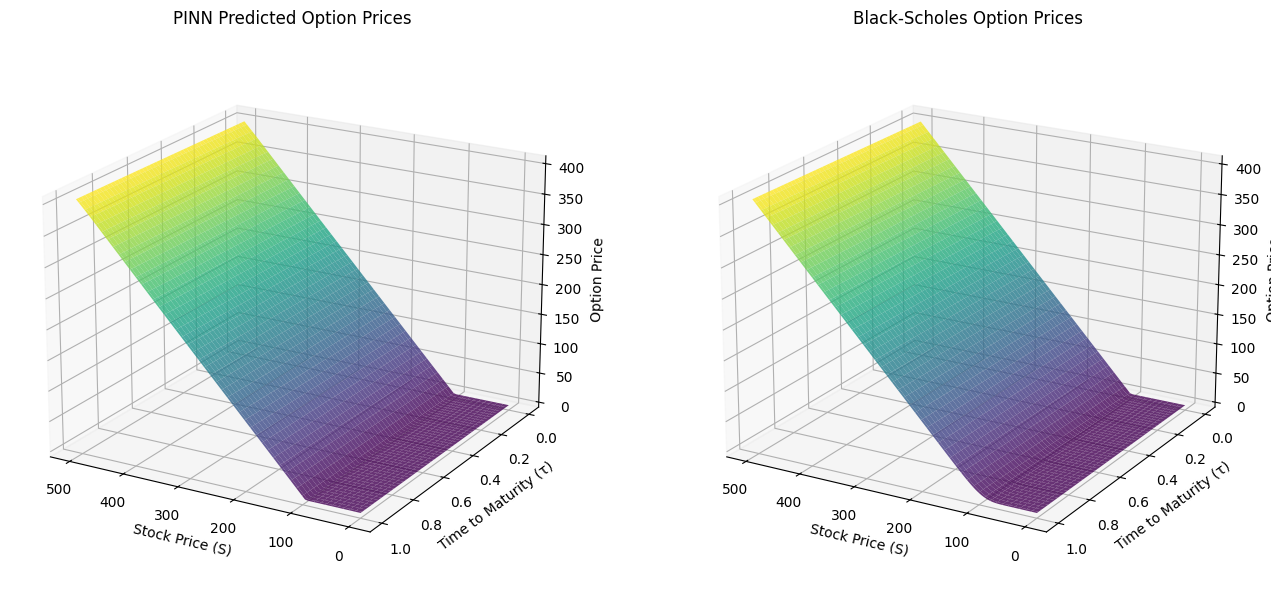

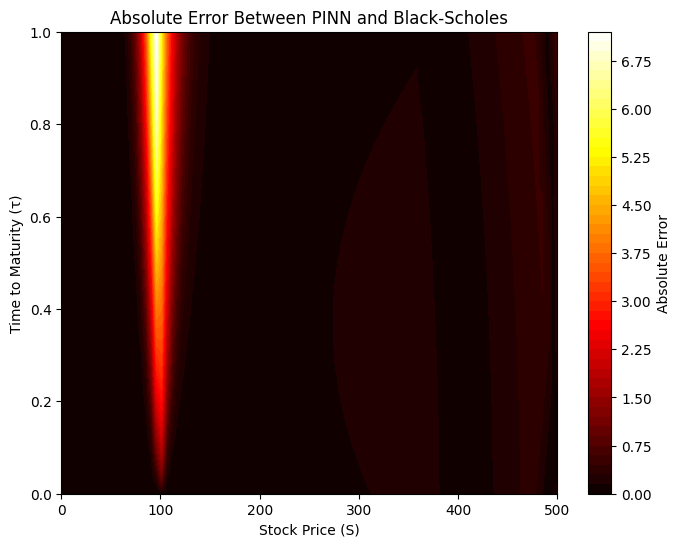

In [56]:
fig = plt.figure(figsize=(16, 8))

# PINN predictions
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(S_grid, tau_grid, pinn_prices, cmap="viridis", alpha=0.8)
ax1.set_title("PINN Predicted Option Prices")
ax1.set_xlabel("Stock Price (S)")
ax1.set_ylabel("Time to Maturity (τ)")
ax1.set_zlabel("Option Price")
ax1.view_init(elev=20, azim=120)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(S_grid, tau_grid, bs_prices, cmap="viridis", alpha=0.8)
ax2.set_title("Black-Scholes Option Prices")
ax2.set_xlabel("Stock Price (S)")
ax2.set_ylabel("Time to Maturity (τ)")
ax2.set_zlabel("Option Price")
ax2.view_init(elev=20, azim=120)

plt.show()

absolute_error = np.abs(bs_prices - pinn_prices)

plt.figure(figsize=(8, 6))
plt.contourf(S_grid, tau_grid, absolute_error, levels=50, cmap="hot")
plt.colorbar(label="Absolute Error")
plt.title("Absolute Error Between PINN and Black-Scholes")
plt.xlabel("Stock Price (S)")
plt.ylabel("Time to Maturity (τ)")
plt.show()